In [1]:
%run ../nn_option_pricer/_key_imports.py

import sys

sys.path.append("../")
from nn_option_pricer.nn_archi import *
from nn_option_pricer.bachelier import *
from nn_option_pricer.utils import plot_loss, trainable_params
%run ../nn_option_pricer/default_config.py

In [2]:
X_df_train = pd.read_csv("datasets/bachelier_train.csv")
feat_names = list(X_df_train.columns[:N_ASSETS])
f_to_i = lambda x: feat_names.index(x)

N_ASSETS = len([x for x in X_df_train.columns if x.find("asset_") == 0])
N_FEATS = N_ASSETS

Xs_train = X_df_train.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_train = X_df_train["call_payoff"].values.astype(np.float32)
grads_train = X_df_train.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)

X_df_test = pd.read_csv("datasets/bachelier_test.csv")
Xs_test = X_df_test.iloc[:, :N_ASSETS].values.astype(np.float32)
ys_test = X_df_test["call_payoff"].values.astype(np.float32)
grads_test = X_df_test.iloc[:, N_ASSETS : (2 * N_ASSETS)].values.astype(np.float32)


X_tensor = tf.Variable(Xs_test)

all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

intrinsic_val = (np.maximum(X_df_test["basket"] - 1.0, 0)
)
upper_bound = None
all_res = []

In [3]:
# """
# Neural Network Hyperparameters
# """
# HIDDEN_UNITS = 512
# LAYERS = 1
# dropout_ratio = 0.0
# HIDDEN_ACT = "softplus"

# OUTPUT_ACT = None
# DROPOUT_RATIO = 0.0
LR = 1e-4
nn_params["n_feats"] = N_FEATS
# BATCH_SIZE = 32
# EPOCHS = 30
# BATCH_NORM = False
loss_weights = (ys_train > 0)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

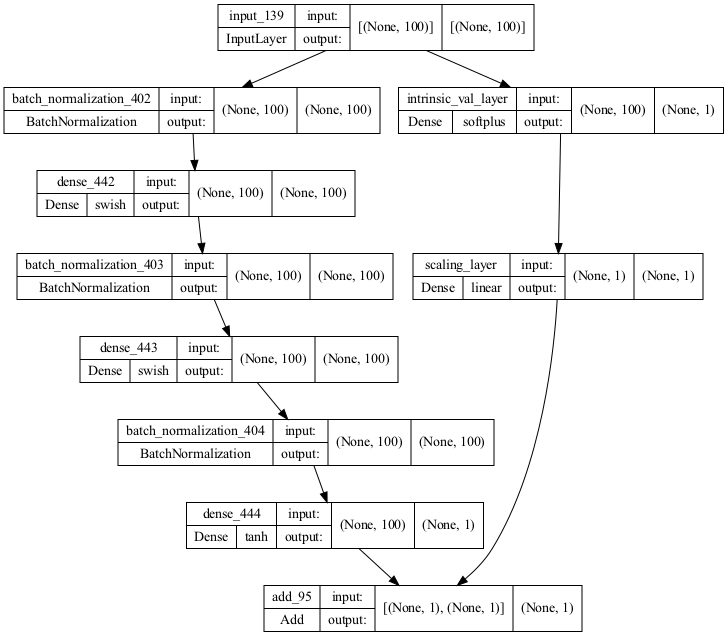

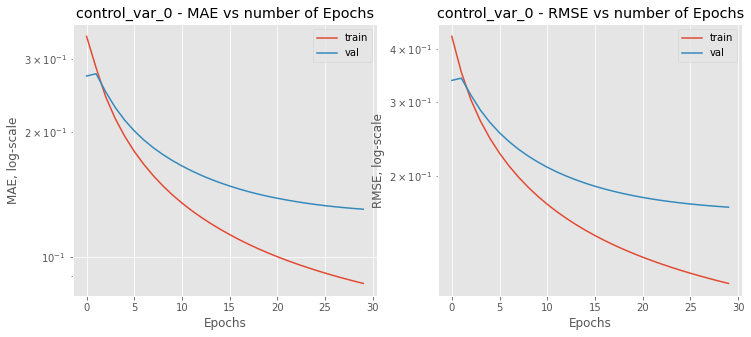

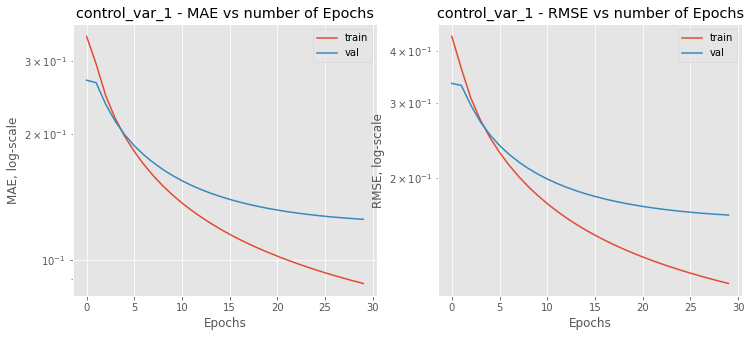

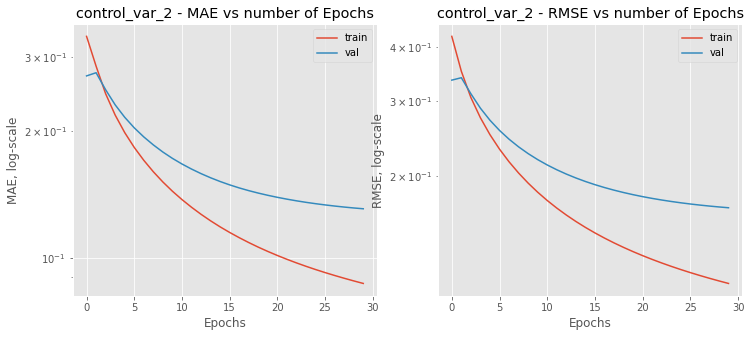

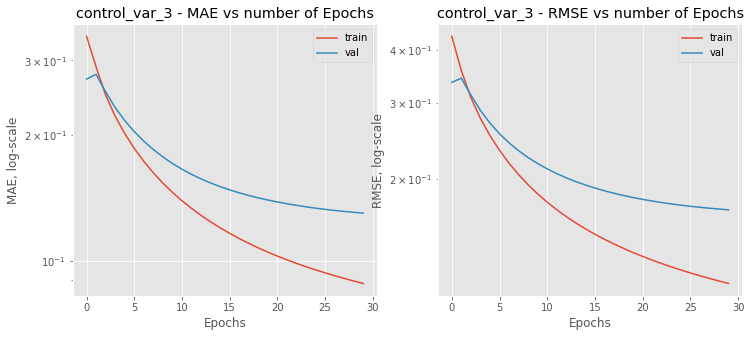

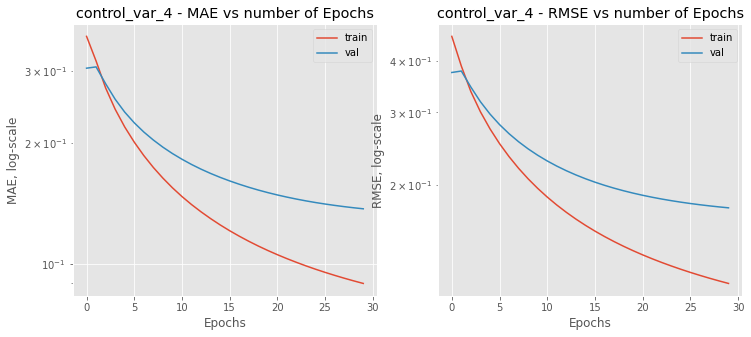

In [322]:
for METHOD_TYPE in ["control_var"]:#, "ffn", "resnet", "differential"]:
    for i in range(5):
        metrics_to_add = []
        opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=500,
            decay_rate=0.95,
        ))
        METHOD = f"{METHOD_TYPE}_{i}"
        nn_params2 = nn_params.copy()
        nn_params2["seed"] = 2022 + i
        if METHOD_TYPE == "resnet":
            nn_params2["resnet"] = True
        all_models[METHOD] = make_model(**nn_params2)
        if METHOD_TYPE == "differential":
            all_models[METHOD] = DifferentialModel(all_models[METHOD].input, all_models[METHOD].outputs)
            all_models[METHOD].set_params(lam = 10**6, grad_loss_fn = tf.keras.losses.MeanSquaredError())
            metrics_to_add = ["grad_loss"]
        if METHOD_TYPE == "control_var":
            nn_params2["output_act"] = "tanh"
            model2 = make_model(**nn_params2)
            intrinsic_val_layer = tf.keras.layers.Dense(1, activation='softplus', name='intrinsic_val_layer')(model2.layers[0].input)
            intrinsic_val_layer = tf.keras.layers.Dense(1, use_bias=False, name="scaling_layer")(intrinsic_val_layer)
            a = 10.0
            output_layer = Add()([model2.layers[-1].output, intrinsic_val_layer])
            all_models[METHOD] = Model(model2.inputs, output_layer)
            for x in all_models[METHOD].layers:
                if x.name == "intrinsic_val_layer":
                    x.set_weights([np.ones((N_ASSETS, 1)) / (N_ASSETS) * a, np.array([-a])])
                    x.trainable = False
                if x.name == "scaling_layer":
                    x.set_weights([np.array([[1.0 / a]])])
            # all_models[METHOD].layers[-3].set_weights([np.zeros(all_models[METHOD].layers[-3].get_weights()[0].shape), np.array([0.0])])
            
        all_models[METHOD].compile(optimizer=opt, **compile_params,  loss_weights=loss_weights)
        """
        Training
        """
        start = time.time()
        if METHOD_TYPE == "differential":
            train_time, history = train_nn(all_models[METHOD], Xs_train, (ys_train, grads_train), fit_params, metric_names + metrics_to_add, METHOD)   
        else:
            train_time, history = train_nn(all_models[METHOD], Xs_train, ys_train, fit_params, metric_names + metrics_to_add, METHOD)   

        start2 = time.time()
        with tf.GradientTape() as model_tape:
            output = all_models[METHOD](X_tensor)
            model_grads = model_tape.gradient(output, X_tensor)
        
        all_model_preds[METHOD] = output.numpy().reshape(-1)
        all_model_grads[METHOD] = model_grads.numpy()
        factor_grad = all_model_grads[METHOD].mean(axis = 1)
        inference_time = time.time() - start2

        temp = bachelier_eval_wrapper(
            X_df_test,
            X_df_test["call_analytic"].values,
            all_model_preds[METHOD],
            factor_grad,
            lower_bound=intrinsic_val,
            upper_bound=upper_bound,
            METHOD=METHOD,
            plots = []
        )
        temp["inference_time"] = inference_time
        temp["train_time"] = train_time
        temp["model_complexity"] = trainable_params(all_models[METHOD])
        all_res += [temp.copy()]
    
    
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))

In [268]:
all_models[METHOD].layers[-3].name

'dense_369'

In [314]:
if METHOD_TYPE == "control_var":
    nn_params2["output_act"] = "tanh"
    model2 = make_model(**nn_params2)
    intrinsic_val_layer = tf.keras.layers.Dense(1, activation='softplus', name='intrinsic_val_layer')(model2.layers[0].input)
    intrinsic_val_layer = tf.keras.layers.Dense(1, use_bias=False, name="scaling_layer")(intrinsic_val_layer)
    a = 10.0
    output_layer = Add()([model2.layers[-1].output, intrinsic_val_layer])
    all_models[METHOD] = Model(model2.inputs, output_layer)
    for x in all_models[METHOD].layers:
        if x.name == "intrinsic_val_layer":
            x.set_weights([np.ones((N_ASSETS, 1)) / (N_ASSETS) * a, np.array([-a])])
            x.trainable = False
        if x.name == "scaling_layer":
            x.set_weights([np.array([[1.0 / a]])])
            # x.set_weights([np.array([[0.0]])])
            # x.trainable = False
    # all_models[METHOD].layers[-3].set_weights([np.zeros(all_models[METHOD].layers[-3].get_weights()[0].shape), np.array([0.0])])

all_models[METHOD].compile(optimizer=opt, **compile_params,  loss_weights=loss_weights)

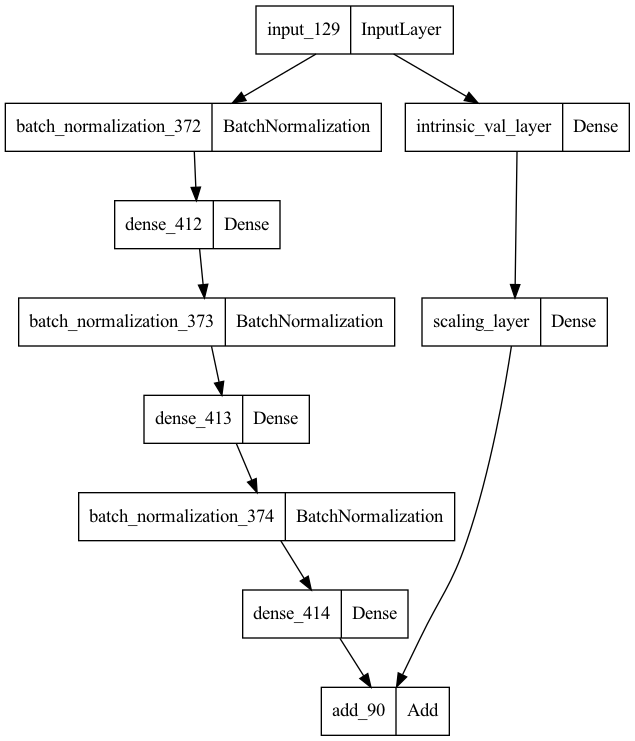

In [315]:
tf.keras.utils.plot_model(all_models[METHOD])

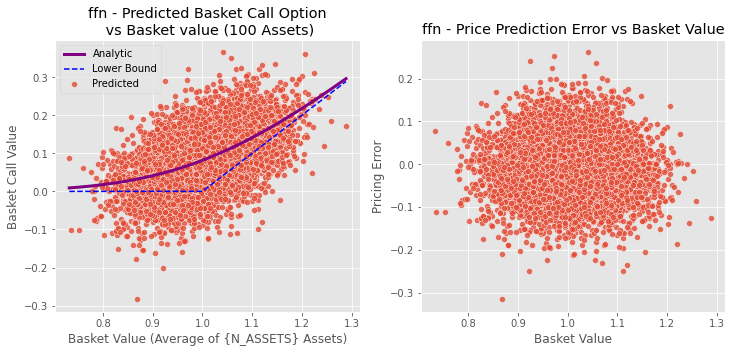

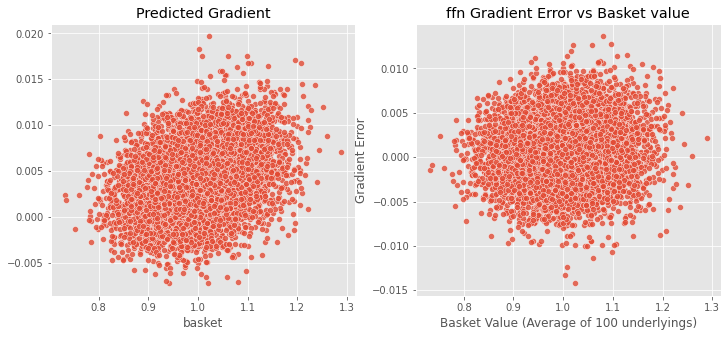

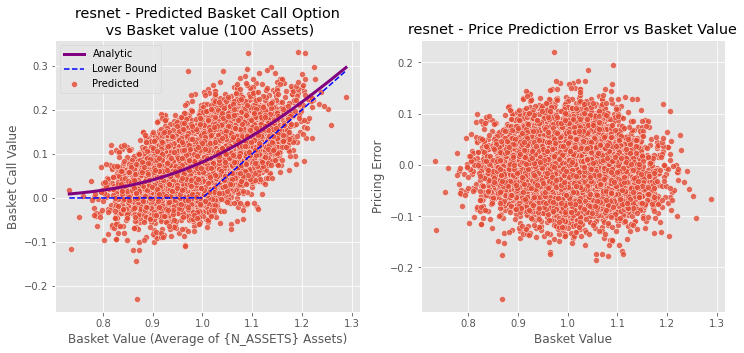

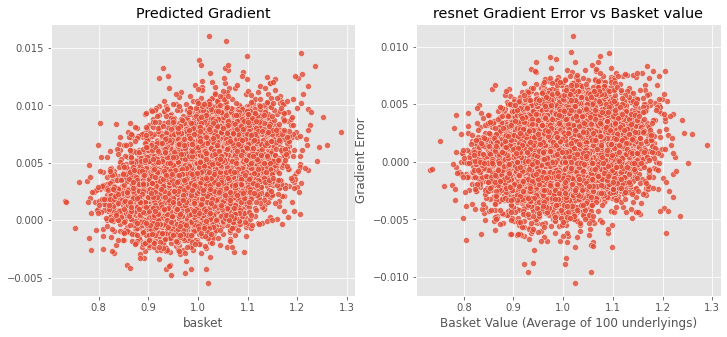

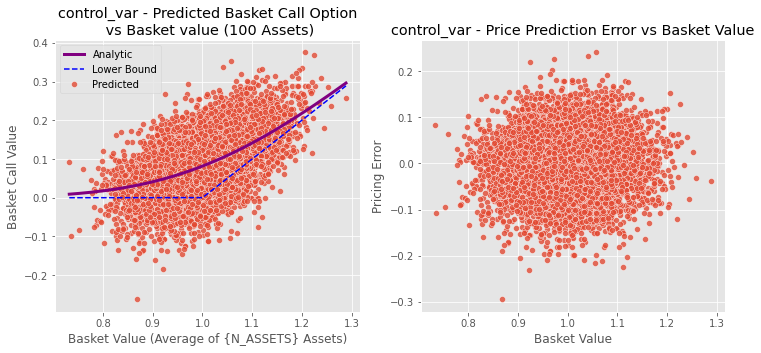

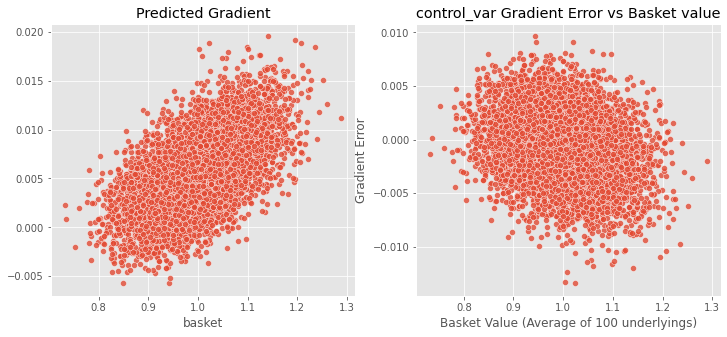

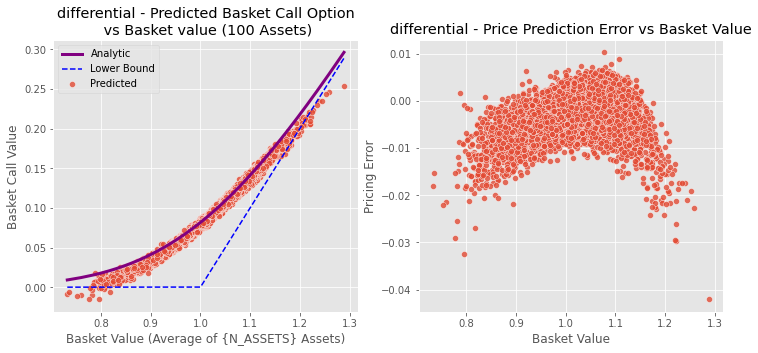

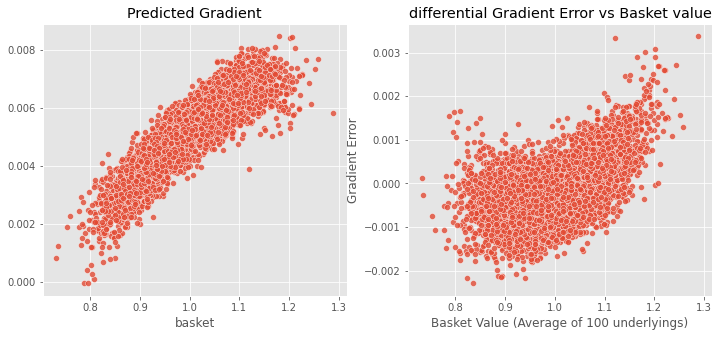

In [325]:
for METHOD in ["ffn", "resnet", "control_var", "differential"]:
    pred = pd.DataFrame({i: all_model_preds[f"{METHOD}_{i}"] for i in range(5)}).mean(axis = 1).values
    grad = pd.concat([pd.DataFrame({0: all_model_grads[f"{METHOD}_{i}"][:,j] for i in range(5)}).mean(axis = 1) for j in range(N_ASSETS)], axis = 1).values

    bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic"].values,
        pred,
        grad.mean(axis = 1),
        lower_bound=intrinsic_val,
        upper_bound=upper_bound,
        METHOD=METHOD,
    )



In [ ]:

temp = bachelier_eval_wrapper(
    X_df_test,
    X_df_test["call_analytic"].values,
    all_model_preds[METHOD],
    all_model_grads[METHOD].mean(axis = 1),
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

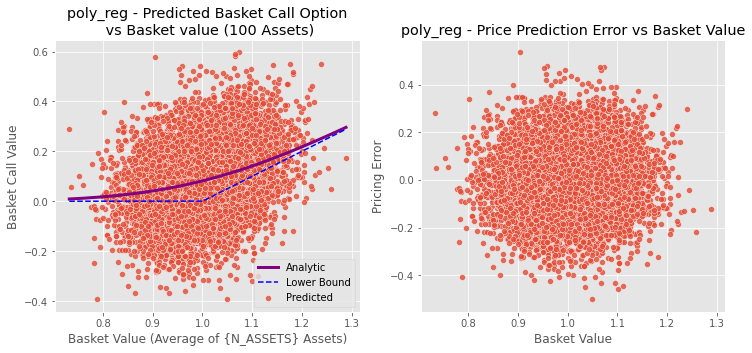

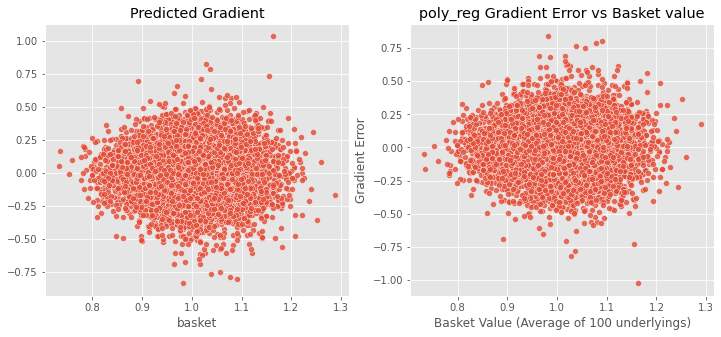

In [13]:
from nn_option_pricer.poly_reg import train_infer_poly
import math


METHOD = "poly_reg"
start = time.time()
degree = round((nn_params["hidden_units"]) ** (1/ N_FEATS))
degree = 2
# spline = SplineTransformer(n_knots=5, degree=10, knots="uniform", extrapolation="linear")
train_time, inference_time = train_infer_poly(degree, Xs_train, ys_train, Xs_test, ys_test, feat_names, all_models, all_model_preds, all_model_grads, all_model_hessian, f_to_i, moneyness_var="asset_0", METHOD="poly_reg", eps=1e-4)
temp = bachelier_eval_wrapper(
    X_df_test,
    X_df_test["call_analytic"].values,
    all_model_preds[METHOD],
    all_model_grads[METHOD].mean(axis = 1),
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

temp['train_time'] = train_time
temp["model_parameters"] = len(all_models[METHOD]['lr'].coef_)
temp['inference_time'] = inference_time
all_res += [temp.copy()]

## Monte Carlo (Pre-Computed)

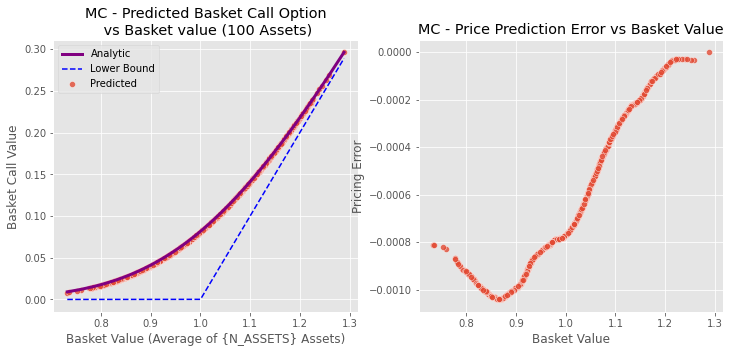

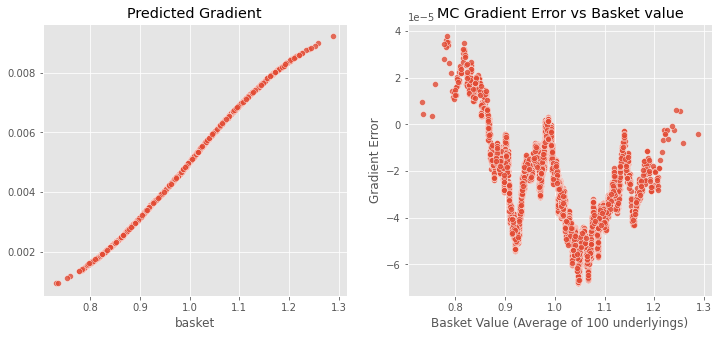

In [14]:
all_res += [
    bachelier_eval_wrapper(
        X_df_test,
        X_df_test["call_analytic_delta"].values,
        X_df_test["call_MC"].values,
        X_df_test["delta_MC"].values,
        lower_bound=intrinsic_val,
        upper_bound=upper_bound,
        METHOD="MC",
    )
]

## Results

In [323]:
res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"])
    .set_index("index")
    .T
)
res_df.loc["inference_time", "MC"] = 131.37
display(res_df.style.background_gradient(axis=1))
print(res_df.style.format("{:.5f}").to_latex())
res_df.to_csv("results/bachelier_long.csv")

index,control_var_0,control_var_1,control_var_2,control_var_3,control_var_4,ffn_0,ffn_1,ffn_2,ffn_3,ffn_4,resnet_0,resnet_1,resnet_2,resnet_3,resnet_4,differential_0,differential_1,differential_2,differential_3,differential_4,poly_reg,MC
pred_l1,0.308628,0.302967,0.312673,0.305238,0.308697,0.092562,0.091516,0.097223,0.097377,0.106030,0.069856,0.067731,0.073636,0.073209,0.076970,0.005644,0.005556,0.005306,0.005253,0.005171,0.102290,0.000703
pred_l2,0.389450,0.381951,0.393698,0.385413,0.389205,0.119279,0.118085,0.124502,0.124707,0.136043,0.090116,0.087033,0.093833,0.093642,0.098419,0.007380,0.007438,0.006916,0.007110,0.006798,0.129159,0.000735
pred_l_inf,1.662452,1.553296,1.600049,1.739174,1.675016,0.588635,0.563788,0.562984,0.629659,0.614777,0.542785,0.429306,0.526640,0.527328,0.522430,0.049466,0.050003,0.043634,0.062353,0.044453,0.535222,0.001041
pred_lower_bound_violation,0.439300,0.421500,0.448000,0.428800,0.437400,0.304800,0.304000,0.318200,0.329800,0.334400,0.255400,0.245200,0.267900,0.278500,0.277300,0.005200,0.008300,0.004700,0.007800,0.005400,0.321600,0.000000
grad_l1,0.010621,0.009469,0.009906,0.010122,0.010691,0.002720,0.003005,0.002631,0.003093,0.002653,0.002287,0.002230,0.002083,0.002567,0.002121,0.000621,0.000697,0.000557,0.000636,0.000506,0.134554,0.000030
grad_l2,0.013313,0.011860,0.012368,0.012690,0.013370,0.003422,0.003727,0.003316,0.003863,0.003329,0.002897,0.002757,0.002596,0.003197,0.002632,0.000759,0.000883,0.000686,0.000851,0.000631,0.172429,0.000034
grad_l_inf,0.050681,0.049449,0.046174,0.053464,0.051116,0.013768,0.013808,0.014279,0.017983,0.014228,0.012447,0.009743,0.009738,0.013667,0.010901,0.003392,0.004854,0.003407,0.008166,0.003375,1.026712,0.000068
grad_lower_bound_violation,0.254100,0.241200,0.255900,0.238700,0.263600,0.092100,0.152900,0.109000,0.159300,0.109800,0.053500,0.034500,0.047300,0.087800,0.052600,0.000000,0.000000,0.000000,0.000000,0.000200,0.486000,0.000000
inference_time,1.866276,1.862891,1.462796,1.602372,1.272914,0.065869,0.062838,0.060132,0.063040,0.063573,0.069988,0.063745,0.064617,0.066715,0.070008,0.065770,0.077676,0.063738,0.069013,0.064922,54.590180,131.370000
train_time,30.212358,30.013258,31.217830,36.117518,27.350596,14.035407,13.430327,13.396418,13.355379,13.524261,13.460477,13.436490,14.698677,14.024552,13.768148,17.702550,19.932626,19.357803,18.753849,17.900357,24.431461,nan


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrr}
{index} & {control_var_0} & {control_var_1} & {control_var_2} & {control_var_3} & {control_var_4} & {ffn_0} & {ffn_1} & {ffn_2} & {ffn_3} & {ffn_4} & {resnet_0} & {resnet_1} & {resnet_2} & {resnet_3} & {resnet_4} & {differential_0} & {differential_1} & {differential_2} & {differential_3} & {differential_4} & {poly_reg} & {MC} \\
pred_l1 & 0.30863 & 0.30297 & 0.31267 & 0.30524 & 0.30870 & 0.09256 & 0.09152 & 0.09722 & 0.09738 & 0.10603 & 0.06986 & 0.06773 & 0.07364 & 0.07321 & 0.07697 & 0.00564 & 0.00556 & 0.00531 & 0.00525 & 0.00517 & 0.10229 & 0.00070 \\
pred_l2 & 0.38945 & 0.38195 & 0.39370 & 0.38541 & 0.38920 & 0.11928 & 0.11809 & 0.12450 & 0.12471 & 0.13604 & 0.09012 & 0.08703 & 0.09383 & 0.09364 & 0.09842 & 0.00738 & 0.00744 & 0.00692 & 0.00711 & 0.00680 & 0.12916 & 0.00074 \\
pred_l_inf & 1.66245 & 1.55330 & 1.60005 & 1.73917 & 1.67502 & 0.58864 & 0.56379 & 0.56298 & 0.62966 & 0.61478 & 0.54278 & 0.42931 & 0.52664 & 0.52733 & 0.52243 & 0.0

In [328]:
res_df2 = pd.concat(
    [
        res_df[[f"control_var_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"ffn_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"differential_{i}" for i in range(5)]].mean(axis=1),
        res_df[[f"resnet_{i}" for i in range(5)]].mean(axis=1),
        res_df[['poly_reg']],
        res_df["MC"],
    ],
    axis=1,
)
res_df2.columns = ["control_var", "ffn", "differential", "resnet", "poly_reg","MC"]
display(res_df2.style.background_gradient(axis=1))
print(res_df2.to_latex(float_format=".5g"))
res_df2.to_csv("results/bachelier_short.csv")

,control_var,ffn,differential,resnet,poly_reg,MC
pred_l1,0.307641,0.096942,0.005386,0.072280,0.102290,0.000703
pred_l2,0.387943,0.124523,0.007128,0.092609,0.129159,0.000735
pred_l_inf,1.645997,0.591969,0.049982,0.509698,0.535222,0.001041
pred_lower_bound_violation,0.435000,0.318240,0.006280,0.264860,0.321600,0.000000
grad_l1,0.010162,0.002820,0.000604,0.002257,0.134554,0.000030
grad_l2,0.012720,0.003531,0.000762,0.002816,0.172429,0.000034
grad_l_inf,0.050177,0.014813,0.004639,0.011299,1.026712,0.000068
grad_lower_bound_violation,0.250700,0.124620,0.000040,0.055140,0.486000,0.000000
inference_time,1.613450,0.063090,0.068224,0.067015,54.590180,131.370000
train_time,30.982312,13.548359,18.729437,13.877669,24.431461,nan


\begin{tabular}{lrrrrrr}
\toprule
{} &  control\_var &  ffn &  differential &  resnet &  poly\_reg &  MC \\
\midrule
pred\_l1                    &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
pred\_l2                    &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
pred\_l\_inf                 &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
pred\_lower\_bound\_violation &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
grad\_l1                    &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
grad\_l2                    &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
grad\_l\_inf                 &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
grad\_lower\_bound\_violation &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
inference\_time             &          .5g &  .5g &           .5g &     .5g &       .5g & .5g \\
trai

$\frac{\partial^{2} g}{\partial x^{2}} =  \frac{1}{N_{F}^{2}}\frac{\partial}{\partial s} \sum_{j = 1}^{N_{F}} \sum_{i = 1}^{N_{F}} \frac{\partial^{2} g}{\partial s_{i} \partial s_{j}}$

Time to compute Hessian: (s): 15.773035049438477


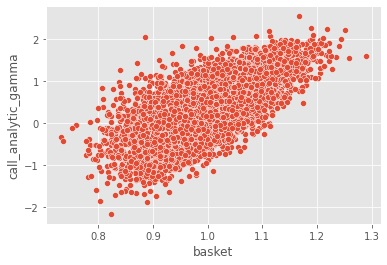

In [329]:
from scipy.linalg import cholesky

SEED = 42
rng = default_rng(SEED)

"""
Define Parameters
"""
N_ASSETS = 100
F = N_ASSETS
N_SAMPLES = 10**4
T = 1.0
K = 1.0

# # Covariance matrix
L = 0.2 * rng.standard_normal((N_ASSETS, F))
cov = L @ L.T
assert np.linalg.det(cov) > 0
L = cholesky(cov)
start = time.time()
with tf.GradientTape() as tape2:
    with tf.GradientTape() as model_tape:
        output = all_models["differential_4"](X_tensor)
    model_grads = model_tape.gradient(output, X_tensor)
jacobian = tape2.batch_jacobian(model_grads, X_tensor)
# j_sum = tf.reduce_sum(jacobian, axis=2)
hessian_det = tf.linalg.trace(L.T @ jacobian @ L)
factor_grad = tf.math.reduce_mean(model_grads, axis=1).numpy()
j_sum = tf.reduce_sum(tf.reduce_sum(jacobian, axis=2), axis = 1)
sns.scatterplot(X_df_test['basket'], X_df_test['call_analytic_gamma'] - j_sum)
# sns.scatterplot(X_df_test["basket"], hessian_det)
end = time.time()
print("Time to compute Hessian: (s):", end - start)